In [1]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
from scipy.signal import (
    butter,
    filtfilt,
    find_peaks,
    find_peaks_cwt,
    medfilt,
    savgol_filter,
)
from utils import butter_lowpass_filter, butter_highpass_filter, smooth, positions2onehot,normalize
import torch
import torch.nn as nn
from test_metric_utils import *
import pandas as pd
%matplotlib inline

In [2]:
def inference(model,Speech,n_frame = 192,window_step = 32):
    assert n_frame%window_step ==0
    model.eval()
    Speech = np.expand_dims(Speech,axis=-1)
    
    EGG_pred = np.zeros_like(Speech)
    ratio = np.zeros_like(Speech)
    
    frame = 0
    while frame*window_step + n_frame <= len(Speech):
        tmp = Speech[frame*window_step:frame*window_step+n_frame]
        tmp = torch.Tensor([normalize(tmp)]).cuda()
        
        result = model(tmp).cpu().detach().numpy()[0]
        EGG_pred[frame*window_step:frame*window_step+n_frame] += result
        ratio[frame*window_step:frame*window_step+n_frame] +=1
        
        frame +=1
    
    for i in range(len(EGG_pred)):
        EGG_pred[i] = EGG_pred[i]/ratio[i]
    return EGG_pred

In [3]:
def Testing_GCI_GOI(EGG_pred, EGG_true,peak_range=(7, 15)):
    
    DEGG_true = np.gradient(EGG_true,edge_order=2)
    DEGG_pred = np.gradient(EGG_pred,edge_order=2)
    GCI_true = detectgroundwaveletgci(EGG_true,peak_range)
    GCI_pred = detectgroundwaveletgci(EGG_pred,peak_range)
    
    GOI_true = []
    GOI_pred = []
    
    for i in range(GCI_true.shape[0] - 1):
        GOI_true.append(GCI_true[i] + np.argmax(DEGG_true[GCI_true[i]+1:GCI_true[i+1]]) + 1)
    for i in range(GCI_pred.shape[0] - 1):
        GOI_pred.append(GCI_pred[i] + np.argmax(DEGG_pred[GCI_pred[i]+1:GCI_pred[i+1]]) + 1)
    
    GOI_true, GOI_pred = np.array(GOI_true), np.array(GOI_pred)
    GOI_true =GOI_true/16000
    GCI_true =GCI_true/16000
    GOI_pred =GOI_pred/16000
    GCI_pred =GCI_pred/16000
    
    GCI_metrics = corrected_naylor_metrics(GCI_true, GCI_pred)
    GOI_metrics = corrected_naylor_metrics(GOI_true, GOI_pred)
#     GCI_IDR,GCI_MR,GCI_FAR,GCI_IDA = GCI_metrics["identification_rate"],GCI_metrics["miss_rate"],GCI_metrics["false_alarm_rate"],GCI_metrics["identification_accuracy"]
#     GOI_IDR,GOI_MR,GOI_FAR,GOI_IDA = GOI_metrics["identification_rate"],GOI_metrics["miss_rate"],GOI_metrics["false_alarm_rate"],GOI_metrics["identification_accuracy"]
    return GCI_metrics,GOI_metrics
    
def Compare(EGG_pred,EGG_true,visualize_id = None):
    if EGG_pred.ndim !=1:
        EGG_pred = np.squeeze(EGG_pred,axis=-1)
    if EGG_true.ndim !=1:
        EGG_true = np.squeeze(EGG_true,axis=-1)
    
    EGG_true =EGG_true[:len(EGG_pred)]
    
    GCI_metrics,GOI_metrics= Testing_GCI_GOI(EGG_pred,EGG_true)
    True_metrics = {}
    Pred_metrics = {}
#     metrics = extract_quotient_metrics(EGG_true,EGG_pred)
    
    
    
#     True_metrics['CQ'] = metrics["CQ_true"]
#     True_metrics['OQ'] = metrics["OQ_true"]
#     True_metrics['SQ'] = metrics["SQ_true"]
    
#     Pred_metrics['CQ'] = metrics["CQ_estimated"]
#     Pred_metrics['OQ'] = metrics["OQ_estimated"]
#     Pred_metrics['SQ'] = metrics["SQ_estimated"]
    
    if visualize_id is not None:
#         TODO: Save PredEGG vs TrueEGG
#         TODO: Save Pred CQ,OQ,SQ vs True CQ,OQ,SQ
#         TODO: Save Pred CQ,OQ,SQ graph vs True CQ,OQ,SQ graph
        print("{} is now saving .. ".format(visualize_id))
        
    return GCI_metrics,GOI_metrics,Pred_metrics,True_metrics

In [14]:
def Testing(model,id,window_step = 32):
    ## Speech, EGG_true를 통해
    Speech,EGG_true=Data[id]
    EGG_pred = inference(model,Speech,n_frame = 192,window_step = window_step)    
    assert EGG_pred.shape[0] == EGG_true.shape[0], "EGG prediction and true shape does not match"
    
    EGG_pred = np.squeeze(EGG_pred,axis=-1)
#     EGG_true = np.squeeze(EGG_true,axis=-1)
    #post processing
#     EGG_pred = normalize(EGG_pred)
#     plt.plot(EGG_pred[7000:10000])
#     plt.plot(EGG_true[7000:10000])
#     print(EGG_pred.shape)
    EGG_pred = smooth(EGG_pred, 49)
    
    plt.plot(EGG_true[5000:5500])
    plt.plot(EGG_pred[5000:5500])
    
    assert EGG_pred.ndim ==1 and EGG_true.ndim == 1
    
    GCI,GOI,Pred_metrics,True_metrics = Compare(EGG_pred,EGG_true)
    print("==============id : {} Testing Start============".format(id))
    print("GCI Detection Test Result")
    print("IDR : {}% MR : {}% FAR : {}% IDA : {}ms".format(GCI['identification_rate']*100,GCI['miss_rate']*100,GCI['false_alarm_rate']*100,GCI['identification_accuracy']*1000))
    print("GOI Detection Test Result")
    print("IDR : {}% MR : {}% FAR : {}% IDA : {}ms".format(GOI['identification_rate']*100,GOI['miss_rate']*100,GOI['false_alarm_rate']*100,GOI['identification_accuracy']*1000))
#     print("..Metric Comparing..")
#     print("CQ {}<->{}".format(Pred_metrics['CQ'],True_metrics['CQ']))
#     print("OQ {}<->{}".format(Pred_metrics['OQ'],True_metrics['OQ']))
#     print("SQ {}<->{}".format(Pred_metrics['SQ'],True_metrics['SQ']))
#     print("HNR {}<->{}".format(Pred_metrics['HNR'],True_metrics['HNR']))
    print("======================================================")
    print()
    print()

In [5]:
from model_unet import Unet
from model_AAE import FCAE
AAE = FCAE()
AAE.encoder = nn.DataParallel(AAE.encoder)
AAE.decoder = nn.DataParallel(AAE.decoder)
AAE.encoder.load_state_dict(torch.load("./models/AAI/199_STZ.pth"))
AAE.decoder.load_state_dict(torch.load("./models/AAI/199_ZTE.pth"))
AAE.cuda()
# unet_model = nn.DataParallel(model)
# unet_model.load_state_dict(torch.load("./models/Unet/best_val.pth"))

FCAE(
  (encoder): DataParallel(
    (module): FCEncoder(
      (module_list): ModuleList(
        (0): Linear(in_features=192, out_features=175, bias=True)
        (1): Linear(in_features=175, out_features=125, bias=True)
        (2): Linear(in_features=125, out_features=100, bias=True)
      )
      (batches): ModuleList(
        (0): BatchNorm1d(175, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): BatchNorm1d(125, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
  )
  (decoder): DataParallel(
    (module): FCDecoder(
      (module_list): ModuleList(
        (0): Linear(in_features=100, out_features=125, bias=True)
        (1): Linear(in_features=125, out_features=175, bias=True)
        (2): Linear(in_features=175, out_features=192, bias=True)
      )
      (batches): ModuleList(
        (0): BatchNorm1d(125, eps=1e-05, momentum=0.1,

In [6]:
unet = Unet(4,10)
unet = nn.DataParallel(unet)
unet.load_state_dict(torch.load("./models/Unet/%d_Unet.pth"))
unet.cuda()

DataParallel(
  (module): Unet(
    (encoder): ModuleList(
      (0): Conv1d(1, 10, kernel_size=(15,), stride=(1,), padding=(7,))
      (1): Conv1d(10, 20, kernel_size=(15,), stride=(1,), padding=(7,))
      (2): Conv1d(20, 30, kernel_size=(15,), stride=(1,), padding=(7,))
      (3): Conv1d(30, 40, kernel_size=(15,), stride=(1,), padding=(7,))
    )
    (decoder): ModuleList(
      (0): Conv1d(80, 40, kernel_size=(5,), stride=(1,), padding=(2,))
      (1): Conv1d(70, 30, kernel_size=(5,), stride=(1,), padding=(2,))
      (2): Conv1d(50, 20, kernel_size=(5,), stride=(1,), padding=(2,))
      (3): Conv1d(30, 10, kernel_size=(5,), stride=(1,), padding=(2,))
    )
    (ebatch): ModuleList(
      (0): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): BatchNorm1d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): BatchNorm1d(40, eps=1

In [7]:
unet_cos = Unet(4,10)
unet_cos = nn.DataParallel(unet_cos)
unet_cos.load_state_dict(torch.load("./models/Unet/35_Unet-cosloss.pth"))
unet_cos.cuda()

DataParallel(
  (module): Unet(
    (encoder): ModuleList(
      (0): Conv1d(1, 10, kernel_size=(15,), stride=(1,), padding=(7,))
      (1): Conv1d(10, 20, kernel_size=(15,), stride=(1,), padding=(7,))
      (2): Conv1d(20, 30, kernel_size=(15,), stride=(1,), padding=(7,))
      (3): Conv1d(30, 40, kernel_size=(15,), stride=(1,), padding=(7,))
    )
    (decoder): ModuleList(
      (0): Conv1d(80, 40, kernel_size=(5,), stride=(1,), padding=(2,))
      (1): Conv1d(70, 30, kernel_size=(5,), stride=(1,), padding=(2,))
      (2): Conv1d(50, 20, kernel_size=(5,), stride=(1,), padding=(2,))
      (3): Conv1d(30, 10, kernel_size=(5,), stride=(1,), padding=(2,))
    )
    (ebatch): ModuleList(
      (0): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): BatchNorm1d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): BatchNorm1d(40, eps=1

In [8]:
window = 192

x,sr = librosa.load('./datasets/cmu_us_bdl_arctic/orig/arctic_b0238.wav',sr = 16000,mono=False)
_Speech,_EGG = x[0],x[1]
itvs = librosa.effects.split(_Speech,frame_length = int(window*0.75), hop_length = int(window*0.5),top_db = 10)

Speech = []
EGG = []
for st,ed in itvs:
    Speech += list(_Speech[st:ed])
    EGG += list(_EGG[st:ed])

Speech = np.array(Speech)
EGG = np.array(EGG)

Speech = butter_lowpass_filter(Speech,2500,16000)

In [9]:
window = 192

_Speech,sr = librosa.load('./datasets/saarbrucken/export/1998-phrase.wav',sr = 48000)
_EGG,sr = librosa.load('./datasets/saarbrucken/export/1998-phrase-egg.wav',sr = 48000)
_Speech = librosa.resample(_Speech,sr,16000)
_EGG = librosa.resample(_EGG,sr,16000)
itvs = librosa.effects.split(_Speech,frame_length = int(window*0.75), hop_length = int(window*0.5),top_db = 10)

Speech = []
EGG = []
for st,ed in itvs:
    Speech += list(_Speech[st:ed])
    EGG += list(_EGG[st:ed])

Speech = np.array(Speech)
EGG = np.array(EGG)

In [30]:
import IPython.display as ipd

ipd.Audio(Speech[5000:11000],rate=16000)

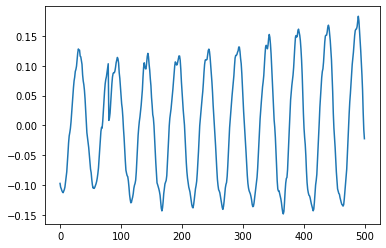

In [26]:
plt.plot(Speech[10000:10500])

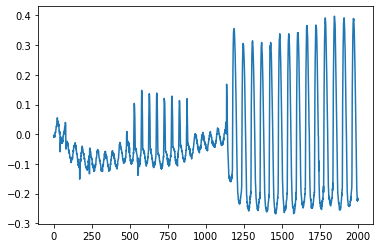

In [25]:

plt.plot(EGG[10000:12000])

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/opt/conda/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


==============id : bdl_b_0238 Testing Start============
GCI Detection Test Result
IDR : 87.64044943820225% MR : 2.247191011235955% FAR : 10.112359550561797% IDA : 0.7114611940822861ms
GOI Detection Test Result
IDR : 84.5360824742268% MR : 5.670103092783505% FAR : 9.793814432989691% IDA : 0.4443792027602677ms




/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:2351: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:2423: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


==============id : bdl_b_0238 Testing Start============
GCI Detection Test Result
IDR : 86.51685393258427% MR : 2.8089887640449436% FAR : 10.674157303370785% IDA : 0.6693088748010253ms
GOI Detection Test Result
IDR : 82.4742268041237% MR : 7.216494845360824% FAR : 10.309278350515463% IDA : 0.2963809108007999ms




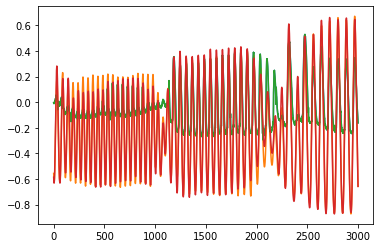

In [10]:
# Speech = Speech[:10000]
# EGG = EG
Data = {}
Data['bdl_b_0238'] = (Speech,EGG)
Testing(AAE,'bdl_b_0238',window_step=32)
Testing(unet,'bdl_b_0238',window_step=32)

==============id : bdl_b_0238 Testing Start============
GCI Detection Test Result
IDR : 88.20224719101124% MR : 1.6853932584269662% FAR : 10.112359550561797% IDA : 0.7066792599139635ms
GOI Detection Test Result
IDR : 83.50515463917526% MR : 6.185567010309279% FAR : 10.309278350515463% IDA : 0.303568691839121ms




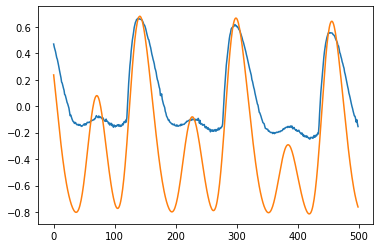

In [15]:
Testing(unet_cos,'bdl_b_0238',window_step=32)

In [ ]:
EGG.shape

In [ ]:
plt.plot(EGG[5000:5300])

==============id : bdl_b_0238 Testing Start============
GCI Detection Test Result
IDR : 88.20224719101124% MR : 1.6853932584269662% FAR : 10.112359550561797% IDA : 0.7066792599139635ms
GOI Detection Test Result
IDR : 83.50515463917526% MR : 6.185567010309279% FAR : 10.309278350515463% IDA : 0.303568691839121ms
======================================================
